--- Network (PINN-SIREN) ---
PINN(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (final_linear): Linear(in_features=64, out_features=1, bias=True)
)
Trainable params: 12737
Starting Adam training...
Ep  2500 | Loss: 3.118e-05 | PDE: 2.373e+01 | BC: 7.447e+00 | Mean(u): 3.11e-03 | LR: 4.3e-04 | λ_bc: 1.0, λ_mean: 1.0
Ep  5000 | Loss: 1.753e-05 | PDE: 1.453e+01 | BC: 3.001e+00 | Mean(u): -3.87e-04 | LR: 2.5e-04 | λ_bc: 1.0, λ_mean: 1.0
Ep  7500 | Loss: 7.374e-06 | PDE: 5.208e+00 | BC: 2.165e+00 | Mean(u): 4.84e-04 | LR: 7.4e-05 | λ_bc: 1.0, λ_mean: 1.0
Ep 10000 | Loss: 6.290e-06 | PDE: 4.289e+00 | BC: 2.001e+00 | Mean(u): 5.00e-04 | LR: 5.0e-

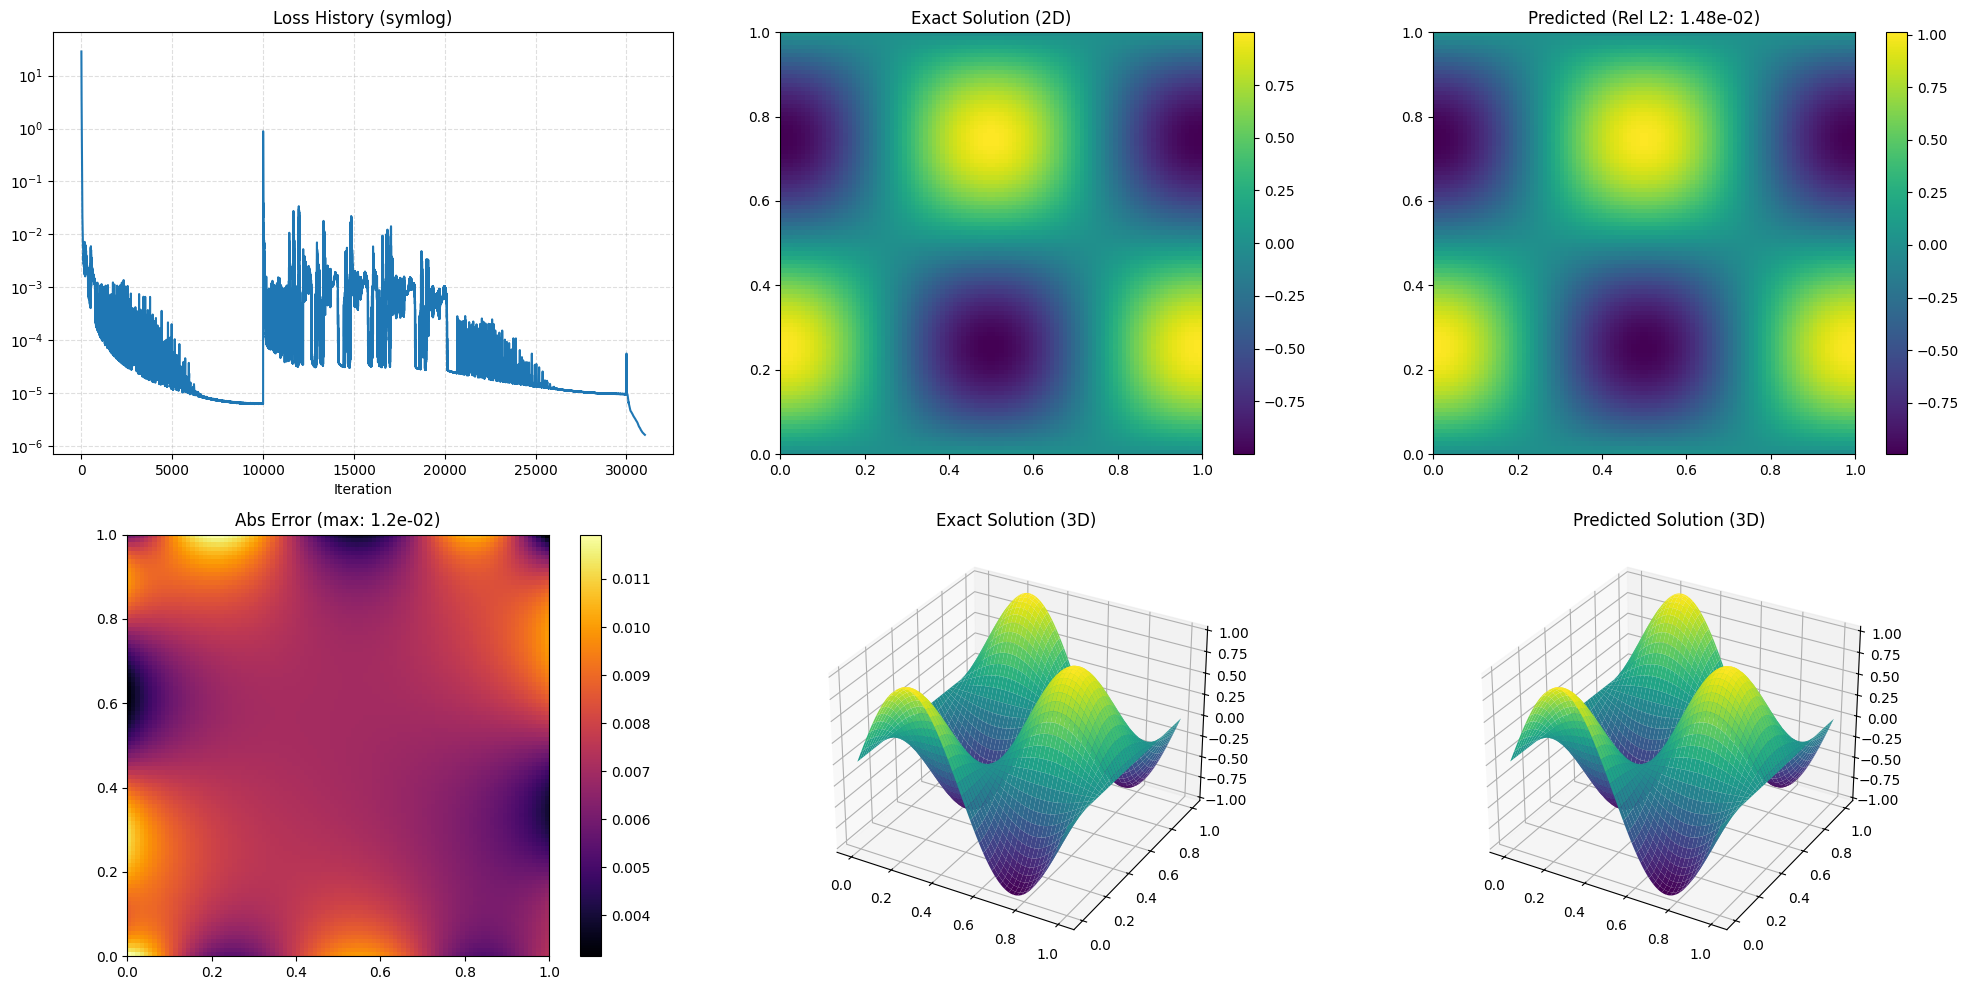

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D plot)
import pickle

# ---------------------------------------------------------------------
# Configuration & Setup
# ---------------------------------------------------------------------
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem: Δ^2 u = f in (0,1)^2 with
# u(x,y) = sin(2πx) cos(2πy)
# g1 = du/dn, g2 = d(Δu)/dn on ∂Ω
# mean(u) = 0

# Hyperparameters (you can tune these)
LAMBDA_BC_MAX = 1000.0       # penalty for boundary conditions
LAMBDA_MEAN_MAX = 200.0      # penalty for mean(u) ≈ 0
LAMBDA_INT = 1.0             # weight for interior terms

EPOCHS_ADAM = 30000          # Adam iterations
EPOCHS_LBFGS = 1000          # LBFGS iterations
LR_MAX = 5e-4                # initial LR for Adam

NUM_POINTS_INT = 10000       # interior Sobol points
NUM_POINTS_BND = 4000        # boundary Sobol points

# scaling for loss to keep gradients numerically nice
LOSS_SCALE = 1e-6


# ---------------------------------------------------------------------
# 1. Neural Network (SIREN-based PINN)
# ---------------------------------------------------------------------
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0=1.0, is_first=False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # First layer init as in SIREN paper
                self.linear.weight.uniform_(
                    -1 / self.linear.in_features,
                    1 / self.linear.in_features
                )
            else:
                # Subsequent layers
                bound = np.sqrt(6 / self.linear.in_features) / self.omega_0
                self.linear.weight.uniform_(-bound, bound)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))


class PINN(nn.Module):
    def __init__(self, num_layers=3, hidden_size=64):
        super().__init__()
        layers = [SineLayer(2, hidden_size, is_first=True, omega_0=1.0)]
        for _ in range(num_layers):
            layers.append(SineLayer(hidden_size, hidden_size, omega_0=1.0))
        self.net = nn.Sequential(*layers)
        self.final_linear = nn.Linear(hidden_size, 1)

        with torch.no_grad():
            bound = np.sqrt(6 / hidden_size)
            self.final_linear.weight.uniform_(-bound, bound)

        self.n_L = sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
        # scale [0,1] -> [0, 2π] for SIREN
        return self.final_linear(self.net(2.0 * np.pi * x))


# ---------------------------------------------------------------------
# 2. Exact Solution & Boundary Data
# ---------------------------------------------------------------------
def exact_u_func(x):
    # u = sin(2πx) cos(2πy)
    return torch.sin(2 * np.pi * x[:, 0:1]) * torch.cos(2 * np.pi * x[:, 1:2])


def get_exact_source(x):
    # For this u, Δ^2 u = 64π^4 u
    u = exact_u_func(x)
    return 64 * (np.pi ** 4) * u


def get_exact_boundary_data(x, n):
    """
    g1 = du/dn, g2 = d(Δu)/dn for exact solution.
    """
    x_temp = x.clone().detach().requires_grad_(True)
    u = exact_u_func(x_temp)

    # grad u
    grad_u = torch.autograd.grad(
        u, x_temp,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]
    g1 = torch.sum(grad_u * n, dim=1, keepdim=True)

    # Laplacian
    u_xx = torch.autograd.grad(
        grad_u[:, 0:1], x_temp,
        grad_outputs=torch.ones_like(grad_u[:, 0:1]),
        create_graph=True
    )[0][:, 0:1]
    u_yy = torch.autograd.grad(
        grad_u[:, 1:2], x_temp,
        grad_outputs=torch.ones_like(grad_u[:, 1:2]),
        create_graph=True
    )[0][:, 1:2]
    lap_u = u_xx + u_yy

    # grad(Δu)
    grad_lap_u = torch.autograd.grad(
        lap_u, x_temp,
        grad_outputs=torch.ones_like(lap_u),
        create_graph=True
    )[0]
    g2 = torch.sum(grad_lap_u * n, dim=1, keepdim=True)

    return g1.detach(), g2.detach()


# ---------------------------------------------------------------------
# 3. Derivatives for PINN (up to bi-Laplacian)
# ---------------------------------------------------------------------
def compute_pinn_derivatives(u, x):
    # grad u
    grad_u = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    # Laplacian parts
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0][:, 0:1]
    u_yy = torch.autograd.grad(
        u_y, x,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0][:, 1:2]
    lap_u = u_xx + u_yy

    # grad(Δu)
    grad_lap_u = torch.autograd.grad(
        lap_u, x,
        grad_outputs=torch.ones_like(lap_u),
        create_graph=True
    )[0]

    # bi-Laplacian
    lap_u_x = grad_lap_u[:, 0:1]
    lap_u_y = grad_lap_u[:, 1:2]

    lap_u_xx = torch.autograd.grad(
        lap_u_x, x,
        grad_outputs=torch.ones_like(lap_u_x),
        create_graph=True
    )[0][:, 0:1]
    lap_u_yy = torch.autograd.grad(
        lap_u_y, x,
        grad_outputs=torch.ones_like(lap_u_y),
        create_graph=True
    )[0][:, 1:2]
    bilap_u = lap_u_xx + lap_u_yy

    return grad_u, grad_lap_u, bilap_u


# ---------------------------------------------------------------------
# 4. PINN Loss Function (Strong form P4)
# ---------------------------------------------------------------------
def loss_function_pinn(model, x_int, x_bnd, n_bnd,
                       f_exact, g1_exact, g2_exact,
                       lambda_bc, lambda_mean):
    # Interior part
    x_int.requires_grad_(True)
    u_int = model(x_int)
    _, _, bilap_u_int = compute_pinn_derivatives(u_int, x_int)

    # PDE residual
    res_pde = bilap_u_int - f_exact
    loss_pde = torch.mean(res_pde ** 2)

    # mean(u) ≈ 0
    mean_u = torch.mean(u_int)
    loss_mean = mean_u ** 2

    loss_int = LAMBDA_INT * loss_pde + lambda_mean * loss_mean

    # Boundary part
    x_bnd.requires_grad_(True)
    u_bnd = model(x_bnd)
    grad_u_bnd, grad_lap_u_bnd, _ = compute_pinn_derivatives(u_bnd, x_bnd)

    du_dn = torch.sum(grad_u_bnd * n_bnd, dim=1, keepdim=True)
    d_lap_u_dn = torch.sum(grad_lap_u_bnd * n_bnd, dim=1, keepdim=True)

    loss_g1 = torch.mean((du_dn - g1_exact) ** 2)
    loss_g2 = torch.mean((d_lap_u_dn - g2_exact) ** 2)

    loss_bc = loss_g1 + loss_g2

    total_loss = loss_int + lambda_bc * loss_bc
    return total_loss, loss_pde, loss_bc, mean_u


# ---------------------------------------------------------------------
# 5. Sobol Sampling
# ---------------------------------------------------------------------
def get_sobol_points(n_int, n_bnd):
    # interior points
    sobol_int = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
    x_int = sobol_int.draw(n_int).to(DEVICE).to(torch.float64)

    # boundary parametrization
    sobol_bnd = torch.quasirandom.SobolEngine(dimension=1, scramble=True)
    n_side = n_bnd // 4
    t = sobol_bnd.draw(n_side).to(DEVICE).to(torch.float64).flatten()
    zeros = torch.zeros_like(t)
    ones = torch.ones_like(t)

    # sides: bottom, top, left, right
    pts = [
        (torch.stack([t, zeros], dim=1), [0., -1.]),
        (torch.stack([t, ones], dim=1),  [0., 1.]),
        (torch.stack([zeros, t], dim=1), [-1., 0.]),
        (torch.stack([ones, t], dim=1),  [1., 0.])
    ]

    x_b_list = []
    n_b_list = []
    for coords, normal in pts:
        x_b_list.append(coords)
        n_b_list.append(torch.tensor([normal], device=DEVICE).repeat(n_side, 1))

    x_b = torch.cat(x_b_list, dim=0)
    n_b = torch.cat(n_b_list, dim=0)

    return x_int, x_b, n_b


# ---------------------------------------------------------------------
# 6. Training Loop
# ---------------------------------------------------------------------
def main():
    model = PINN(num_layers=3, hidden_size=64).to(DEVICE)
    print("--- Network (PINN-SIREN) ---")
    print(model)
    print(f"Trainable params: {model.n_L}")

    optimizer_adam = optim.Adam(model.parameters(), lr=LR_MAX)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_adam,
        T_0=10000,
        T_mult=2,
        eta_min=1e-6
    )

    optimizer_lbfgs = optim.LBFGS(
        model.parameters(),
        lr=0.5,
        max_iter=EPOCHS_LBFGS,
        history_size=100,
        tolerance_grad=1e-9,
        tolerance_change=1e-11,
        line_search_fn="strong_wolfe"
    )

    loss_history = []

    # fixed points for LBFGS
    x_int_fix, x_bnd_fix, n_bnd_fix = get_sobol_points(NUM_POINTS_INT, NUM_POINTS_BND)
    f_fix = get_exact_source(x_int_fix)
    g1_fix, g2_fix = get_exact_boundary_data(x_bnd_fix, n_bnd_fix)

    print("Starting Adam training...")
    for epoch in range(1, EPOCHS_ADAM + 1):
        # curriculum for BC and mean weights
        if epoch <= 10000:
            lam_bc = 1.0
            lam_mean = 1.0
        elif epoch <= 20000:
            alpha = (epoch - 10000) / 10000.0
            lam_bc = 1.0 + alpha * (LAMBDA_BC_MAX - 1.0)
            lam_mean = 1.0 + alpha * (LAMBDA_MEAN_MAX - 1.0)
        else:
            lam_bc = LAMBDA_BC_MAX
            lam_mean = LAMBDA_MEAN_MAX

        # resample points each epoch
        x_int, x_bnd, n_bnd = get_sobol_points(NUM_POINTS_INT, NUM_POINTS_BND)
        f_exact = get_exact_source(x_int)
        g1_exact, g2_exact = get_exact_boundary_data(x_bnd, n_bnd)

        optimizer_adam.zero_grad()
        loss_raw, l_pde, l_bc, mean_u = loss_function_pinn(
            model, x_int, x_bnd, n_bnd,
            f_exact, g1_exact, g2_exact,
            lam_bc, lam_mean
        )

        loss = loss_raw * LOSS_SCALE
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_adam.step()
        scheduler.step()

        loss_history.append(loss.item())

        if epoch % 2500 == 0:
            lr_now = optimizer_adam.param_groups[0]['lr']
            print(
                f"Ep {epoch:5d} | Loss: {loss.item():.3e} | "
                f"PDE: {l_pde.item():.3e} | BC: {l_bc.item():.3e} | "
                f"Mean(u): {mean_u.item():.2e} | LR: {lr_now:.1e} | "
                f"λ_bc: {lam_bc:.1f}, λ_mean: {lam_mean:.1f}"
            )

    # LBFGS polish on fixed dataset
    print("Running LBFGS polish...")

    def closure():
        optimizer_lbfgs.zero_grad()
        loss_raw, _, _, _ = loss_function_pinn(
            model, x_int_fix, x_bnd_fix, n_bnd_fix,
            f_fix, g1_fix, g2_fix,
            LAMBDA_BC_MAX, LAMBDA_MEAN_MAX
        )
        loss = loss_raw * LOSS_SCALE
        loss.backward()
        loss_history.append(loss.item())
        return loss

    optimizer_lbfgs.step(closure)
    print(f"Final scaled loss: {loss_history[-1]:.3e}")

    # -----------------------------------------------------------------
    # 7. Evaluation: L2, H1, H2 errors
    # -----------------------------------------------------------------
    print("\n--- Computing Final Errors ---")
    n_test = 100
    x1 = torch.linspace(0, 1, n_test)
    x2 = torch.linspace(0, 1, n_test)
    X, Y = torch.meshgrid(x1, x2, indexing='ij')
    x_test = torch.stack([X.flatten(), Y.flatten()], dim=1).to(DEVICE)
    x_test.requires_grad_(True)

    u_exact = exact_u_func(x_test)
    u_pred = model(x_test)

    # gradients
    grad_u_p, _, _ = compute_pinn_derivatives(u_pred, x_test)
    grad_u_e, _, _ = compute_pinn_derivatives(u_exact, x_test)

    # Hessians for H2 norm
    def get_hessian(u, x):
        grads = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        ux, uy = grads[:, 0:1], grads[:, 1:2]
        uxx = torch.autograd.grad(
            ux, x,
            grad_outputs=torch.ones_like(ux),
            create_graph=True
        )[0][:, 0:1]
        uxy = torch.autograd.grad(
            ux, x,
            grad_outputs=torch.ones_like(ux),
            create_graph=True
        )[0][:, 1:2]
        uyx = torch.autograd.grad(
            uy, x,
            grad_outputs=torch.ones_like(uy),
            create_graph=True
        )[0][:, 0:1]
        uyy = torch.autograd.grad(
            uy, x,
            grad_outputs=torch.ones_like(uy),
            create_graph=True
        )[0][:, 1:2]
        return torch.cat([uxx, uxy, uyx, uyy], dim=1)

    hess_pred = get_hessian(u_pred, x_test)
    hess_exact = get_hessian(u_exact, x_test)

    # squared errors
    err_u_sq = torch.sum((u_pred - u_exact) ** 2).item()
    err_grad_sq = torch.sum((grad_u_p - grad_u_e) ** 2).item()
    err_hess_sq = torch.sum((hess_pred - hess_exact) ** 2).item()

    norm_u_sq = torch.sum(u_exact ** 2).item()
    norm_h1_sq = norm_u_sq + torch.sum(grad_u_e ** 2).item()
    norm_h2_sq = norm_h1_sq + torch.sum(hess_exact ** 2).item()

    rel_l2 = np.sqrt(err_u_sq / norm_u_sq)
    rel_h1 = np.sqrt((err_u_sq + err_grad_sq) / norm_h1_sq)
    rel_h2 = np.sqrt((err_u_sq + err_grad_sq + err_hess_sq) / norm_h2_sq)

    print(f"Rel L2 Error : {rel_l2:.4e}")
    print(f"Rel H1 Error : {rel_h1:.4e}")
    print(f"Rel H2 Error : {rel_h2:.4e}")

    # -----------------------------------------------------------------
    # 8. Save & Plot
    # -----------------------------------------------------------------
    with open("pinn_loss_history.pkl", "wb") as f:
        pickle.dump(loss_history, f)
    torch.save(model.state_dict(), "pinn_p4_model.pth")

    u_pred_np = u_pred.detach().cpu().numpy().reshape(n_test, n_test)
    u_exact_np = u_exact.detach().cpu().numpy().reshape(n_test, n_test)
    X_np = X.detach().cpu().numpy()
    Y_np = Y.detach().cpu().numpy()

    fig = plt.figure(figsize=(20, 10))

    # 1. Loss (symlog scale to keep sign)
    ax1 = fig.add_subplot(2, 3, 1)
    loss_arr = np.array(loss_history)
    ax1.plot(loss_arr)
    ax1.set_title("Loss History (symlog)")
    ax1.set_xlabel("Iteration")
    ax1.set_yscale("symlog", linthresh=1e-6)
    ax1.grid(True, which="both", linestyle="--", alpha=0.4)

    # 2. Exact 2D
    ax2 = fig.add_subplot(2, 3, 2)
    im2 = ax2.imshow(u_exact_np, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
    ax2.set_title("Exact Solution (2D)")
    plt.colorbar(im2, ax=ax2)

    # 3. Predicted 2D
    ax3 = fig.add_subplot(2, 3, 3)
    im3 = ax3.imshow(u_pred_np, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
    ax3.set_title(f"Predicted (Rel L2: {rel_l2:.2e})")
    plt.colorbar(im3, ax=ax3)

    # 4. Error 2D
    ax4 = fig.add_subplot(2, 3, 4)
    err_map = np.abs(u_pred_np - u_exact_np)
    im4 = ax4.imshow(err_map, extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
    ax4.set_title(f"Abs Error (max: {np.max(err_map):.1e})")
    plt.colorbar(im4, ax=ax4)

    # 5. Exact 3D
    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    ax5.plot_surface(X_np, Y_np, u_exact_np, cmap='viridis')
    ax5.set_title("Exact Solution (3D)")

    # 6. Pred 3D
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    ax6.plot_surface(X_np, Y_np, u_pred_np, cmap='viridis')
    ax6.set_title("Predicted Solution (3D)")

    plt.tight_layout()
    plt.savefig("pinn_p4_results.png")
    plt.show()


if __name__ == "__main__":
    main()
